In [0]:
# !curl -s https://course.fast.ai/setup/colab | bash

In [0]:
# %reload_ext autoreload
# %autoreload 2

In [0]:
from fastai.tabular import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/stash/'

Mounted at /content/gdrive


In [0]:
path = Path(base_dir)/Path('rossmann/');path

PosixPath('/content/gdrive/My Drive/Colab Notebooks/stash/rossmann')

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [0]:
#path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [0]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [0]:
n = len(train_df); n

844338

### Experimenting with a sample

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [0]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
98,99,5,"Mar,Jun,Sept,Dec",2030.0,50,6571
1169,57,4,NaN,420.0,51,9820
1517,406,4,"Feb,May,Aug,Nov",8240.0,52,7903
1992,882,4,NaN,30.0,73,6491
2041,931,4,"Jan,Apr,Jul,Oct",1480.0,86,5720


In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
407541,178,2,NaN,1710.0,80,14782
408387,1024,2,NaN,1990.0,59,8569
408490,12,1,"Jan,Apr,Jul,Oct",1070.0,70,12281
408532,54,1,"Feb,May,Aug,Nov",7170.0,63,13190
408698,220,1,NaN,1000.0,64,7365


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
407541,178,2,NaN,1710.0,80,14782
408387,1024,2,NaN,1990.0,59,8569
408490,12,1,"Jan,Apr,Jul,Oct",1070.0,70,12281
408532,54,1,"Feb,May,Aug,Nov",7170.0,63,13190
408698,NaN,1,NaN,1000.0,64,7365


In [0]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [0]:
small_train_df['PromoInterval'].cat.codes[:5]

98      2
1169   -1
1517    0
1992   -1
2041    1
dtype: int8

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [0]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
359964,879,2,"Feb,May,Aug,Nov",2390.0,60,3649,True
363112,622,4,NaN,2390.0,68,4429,True


### Preparing full data set

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [0]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [0]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [0]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

In [0]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [0]:
doc(FloatList) # tells fastai to consider dep_var as float not int ---> regression pb, not classif pb
# log = True argument passed to label_cls i.e. to FloatList, who ll take log of dep_var and make it dep_var

In [0]:
data.save(base_dir + 'rossmann_databunch.pkl')

## Model

In [0]:
data = load_data(base_dir, 'rossmann_databunch.pkl')#, bs=bs)

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [0]:
# ps are the p values (proba) for dropout in each layer, int or list of ints

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [0]:
len(data.train_ds.cont_names) # batchnorm applied to continuous vara, helps us having higher lr as smoother loss corve

16

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


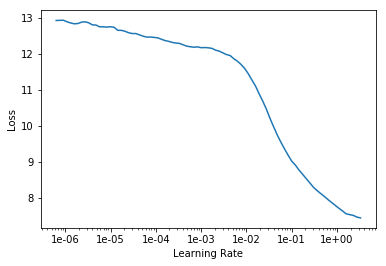

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.024904,0.020503,0.144118,03:42
1,0.019880,0.018761,0.129710,03:43
2,0.017701,0.018613,0.124276,03:42
3,0.013051,0.012555,0.113390,03:44
4,0.010230,0.012639,0.106772,03:43


In [0]:
learn.save('1')

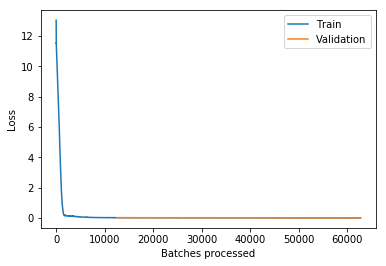

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.load('1');

In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011304,0.013291,0.112541,03:44
1,0.013299,0.014725,0.123745,03:43
2,0.011905,0.016324,0.133795,03:44
3,0.009479,0.014747,0.125335,03:43
4,0.008771,0.015793,0.113188,03:46


In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010491,0.019024,0.136654,03:45
1,0.011177,0.016583,0.114470,03:44
2,0.010911,0.020945,0.139140,03:43
3,0.009332,0.014394,0.118510,03:44
4,0.009979,0.014892,0.117614,03:44


(10th place in the competition was 0.108)

In [0]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
# test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

In [0]:
test_df[["Id","Sales"]].to_csv(path/'rossmann_submission.csv',index=False)